# Uczenie przez wzmacnianie na przykładzie środowiska **CartPole-v1** w Gymnasium

Ten notatnik demonstruje dwie klasyczne metody uczenia przez wzmacnianie:
**Q‑learning** oraz **SARSA**.  Celem jest porównanie ich skuteczności na
środowisku `CartPole-v1` z biblioteki **gymnasium** przy różnych
ustawieniach hiperparametrów (współczynnika uczenia `α`, czynnika
dyskontowania `γ` oraz strategii eksploracji ε‑greedy).


In [3]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import time
from typing import Tuple, List, Dict
%matplotlib inline

## Dyskretyzacja przestrzeni stanów
`CartPole` zwraca ciągły wektor stanu (4 wartości).  Na potrzeby metod
tablicowych (Q‑table) dyskretyzujemy każdą składową do zadanej liczby
przedziałów.

In [4]:
def create_uniform_bins(low: np.ndarray, high: np.ndarray, bins: Tuple[int, ...]):
    """Zwraca listę krawędzi podziału każdej składowej stanu."""
    return [np.linspace(l, h, b - 1) for l, h, b in zip(low, high, bins)]

def discretize(obs: np.ndarray, bins) -> Tuple[int, ...]:
    """Mapuje obserwację ciągłą na dyskretny stan (krotkę indeksów)."""
    return tuple(int(np.digitize(o, b)) for o, b in zip(obs, bins))

## Polityka ε‑greedy
W trakcie uczenia korzystamy z polityki ε‑greedy, z możliwością
logarytmicznego lub liniowego wygaszania ε.

In [5]:
def epsilon_greedy_action(Q: np.ndarray, state: Tuple[int, ...], epsilon: float, n_actions: int):
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)
    return int(np.argmax(Q[state]))

## Funkcje treningowe

In [6]:
def q_learning(env_name: str,
               bins: Tuple[int, ...] = (6, 6, 12, 12),
               episodes: int = 1000,
               alpha: float = 0.1,
               gamma: float = 0.99,
               eps_start: float = 1.0,
               eps_end: float = 0.01,
               eps_decay: float = 0.995):
    env = gym.make(env_name)
    n_actions = env.action_space.n

    bins_list = create_uniform_bins(env.observation_space.low, env.observation_space.high, bins)
    Q = np.zeros(bins + (n_actions,))
    rewards = []
    epsilon = eps_start
    start_time = time.perf_counter()

    for ep in range(episodes):
        obs, info = env.reset(seed=None)
        state = discretize(obs, bins_list)
        total_reward = 0

        done = False
        while not done:
            action = epsilon_greedy_action(Q, state, epsilon, n_actions)
            next_obs, reward, term, trunc, _ = env.step(action)
            done = term or trunc
            next_state = discretize(next_obs, bins_list)
            best_next_action = int(np.argmax(Q[next_state]))

            td_target = reward + gamma * Q[next_state][best_next_action] * (not done)
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta

            state = next_state
            total_reward += reward

        rewards.append(total_reward)
        epsilon = max(eps_end, epsilon * eps_decay)

    elapsed = time.perf_counter() - start_time
    env.close()
    return rewards, elapsed


In [7]:
def sarsa(env_name: str,
          bins: Tuple[int, ...] = (6, 6, 12, 12),
          episodes: int = 1000,
          alpha: float = 0.1,
          gamma: float = 0.99,
          eps_start: float = 1.0,
          eps_end: float = 0.01,
          eps_decay: float = 0.995):
    env = gym.make(env_name)
    n_actions = env.action_space.n
    bins_list = create_uniform_bins(env.observation_space.low, env.observation_space.high, bins)
    Q = np.zeros(bins + (n_actions,))
    rewards = []
    epsilon = eps_start
    start_time = time.perf_counter()

    for ep in range(episodes):
        obs, info = env.reset(seed=None)
        state = discretize(obs, bins_list)
        action = epsilon_greedy_action(Q, state, epsilon, n_actions)
        total_reward = 0
        done = False

        while not done:
            next_obs, reward, term, trunc, _ = env.step(action)
            done = term or trunc
            next_state = discretize(next_obs, bins_list)
            next_action = epsilon_greedy_action(Q, next_state, epsilon, n_actions)

            td_target = reward + gamma * Q[next_state][next_action] * (not done)
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta

            state, action = next_state, next_action
            total_reward += reward

        rewards.append(total_reward)
        epsilon = max(eps_end, epsilon * eps_decay)

    elapsed = time.perf_counter() - start_time
    env.close()
    return rewards, elapsed


## Siatka hiperparametrów
Poniższa komórka definiuje kilka wariantów konfiguracji (`alpha`, `gamma`,
oraz strategię eksploracji) i uruchamia oba algorytmy, zapisując czas
obliczeń i uzyskane nagrody.

In [8]:
param_grid = [
    {'alpha': 0.1, 'gamma': 0.99, 'eps_start': 1.0, 'eps_end': 0.01, 'eps_decay': 0.995},
    {'alpha': 0.5, 'gamma': 0.99, 'eps_start': 1.0, 'eps_end': 0.01, 'eps_decay': 0.995},
    {'alpha': 0.1, 'gamma': 0.95, 'eps_start': 1.0, 'eps_end': 0.01, 'eps_decay': 0.995},
    {'alpha': 0.1, 'gamma': 0.99, 'eps_start': 0.1, 'eps_end': 0.1, 'eps_decay': 1.0},  # stałe ε
]

results = []  # lista słowników na wyniki

for params in param_grid:
    q_rewards, q_time = q_learning('CartPole-v1', episodes=1000, **params)
    s_rewards, s_time = sarsa('CartPole-v1', episodes=1000, **params)
    results.append({
        'params': params,
        'Q-learning': {'rewards': q_rewards, 'time': q_time},
        'SARSA': {'rewards': s_rewards, 'time': s_time}
    })
print('Eksperymenty zakończone.')

Eksperymenty zakończone.


## Wizualizacja krzywych uczenia

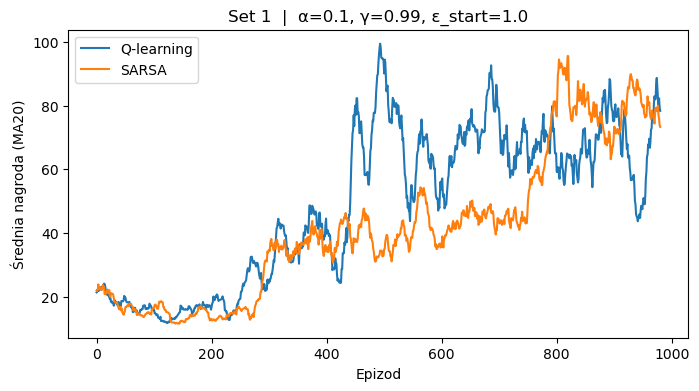

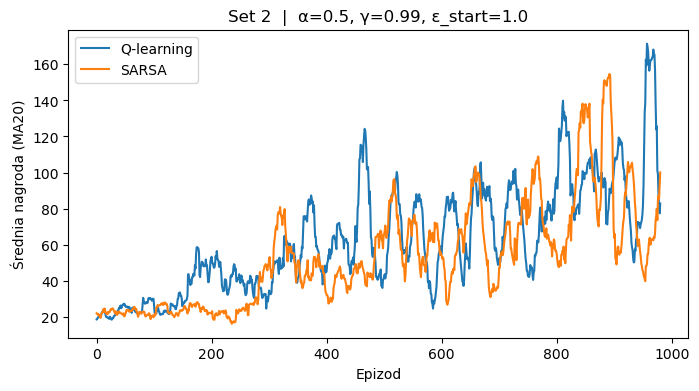

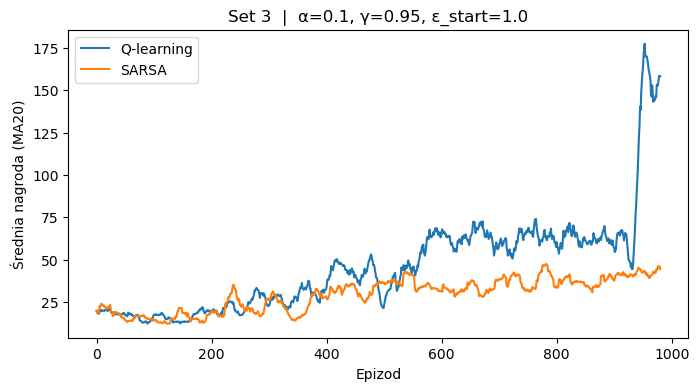

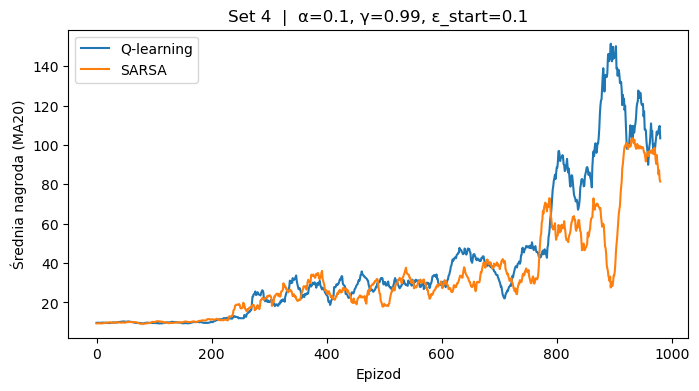

In [9]:
def moving_average(x, w=20):
    return np.convolve(x, np.ones(w)/w, mode='valid')

for idx, res in enumerate(results):
    plt.figure(figsize=(8, 4))
    q_ma = moving_average(res['Q-learning']['rewards'])
    s_ma = moving_average(res['SARSA']['rewards'])
    plt.plot(q_ma, label='Q-learning')
    plt.plot(s_ma, label='SARSA')
    plt.title(f'Set {idx+1}  |  α={res["params"]["alpha"]}, γ={res["params"]["gamma"]}, ε_start={res["params"]["eps_start"]}')
    plt.xlabel('Epizod')
    plt.ylabel('Średnia nagroda (MA20)')
    plt.legend()
    plt.show()


### Wnioski
1. Q-learning zaczął osiągać powyżej 80 punktów praktycznie 2 razy szybciej niż SARSA, ale miał większe oscylacje. SARSA rosła stabilniej i dogoniła go dopiero po ~800 ep.

2. Wyższy α przyspieszył naukę obu algorytmów. Różnica między Q-learning i SARSA zmalała, obie krzywe mają wyraźnie większe ryzyko nadpisywania dobrych wartości.

3. Q-learning utrzymał postęp (skok pkt pod koniec, ale zakładam, że dla większej liczby ep. gwałtownie by spadł - większa oscylacja), lecz SARSA utknęła plus minus 60 pkt. Wrażliwość SARSA na zbyt małe γ okazała się większa.

4. Mała eksploracja od startu spowolniła uczenie (<20 pkt aż do ~400 ep.), ale obie metody dogoniły wyniki z zest. 1 pod koniec. Q-learning pozostał odrobinę lepszy.
